# Lab: Linear Regression
We import our standard libraries at this top
level.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF

from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder


## Simple Linear Regression

We  will use the `Boston` housing data set.  The `Boston` dataset records  `medv`  (median house value) for $506$ neighborhoods
around Boston.  We will build a regression model to predict  `medv`  using $13$
predictors such as  `rmvar`  (average number of rooms per house),
 `age`  (proportion of owner-occupied units built prior to 1940), and  `lstat`  (percent of
households with low socioeconomic status).  We will use `statsmodels` for this
task, a `Python` package that implements several commonly used
regression methods.

In [31]:
Boston = pd.read_csv("11_Boston.csv")

## Let's be a little more methodological in our approach

First we should look at our data.

In [32]:
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


The dataset contains several features related to housing in Boston:

1. crim: per capita crime rate by town
1. zn: proportion of residential land zoned for lots over 25,000 sq.ft.
1. indus: proportion of non-retail business acres per town
1. chas: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
1. nox: nitrogen oxides concentration (parts per 10 million)
1. rm: average number of rooms per dwelling
1. age: proportion of owner-occupied units built prior to 1940
1. dis: weighted mean of distances to five Boston employment centers
1. rad: index of accessibility to radial highways
1. tax: full-value property-tax rate per \$10,000
1. ptratio: pupil-teacher ratio by town
1. lstat: percentage of the population that is of lower status
1. medv: median value of owner-occupied homes in \$1000s (this is our target variable)

In [33]:
# Check the basic statistics
Boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


Before moving to feature scaling, it's important to note that for linear regression models, especially when using the Ordinary Least Squares (OLS) method, feature scaling is primarily done for convergence speed and interpretability. It's not mandatory, but it can help in understanding feature importance more intuitively, especially when variables are on different scales. Although, it changes our interpreation of what the coefficients mean.

However, we'll perform the scaling after splitting the data into training and testing sets to avoid data leakage. Let's first check for missing values.

In [34]:
# Check for missing values in the dataset
Boston.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
medv       0
dtype: int64

Before splitting the data, let's check for multicollinearity among the features using a correlation matrix. Multicollinearity can be problematic for OLS regression, as it can make coefficient estimates unstable.

Use `.corr()` to compute correlation and plot with `sns.heatmap()` setting `annot=True`

<Axes: >

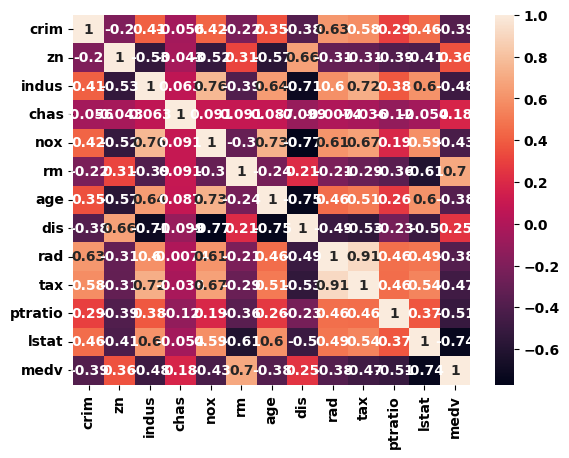

In [35]:
# Compute the correlation matrix
corelations = Boston.corr()

# Plot the correlation heatmap
sns.heatmap(corelations,annot=True)

Watch out we see some features correlated with each other. This cna be a problem remember.

Highly Correlated Features: Some features show a high degree of correlation. For instance:

* indus (proportion of non-retail business acres per town) and nox (nitrogen oxides concentration) have a correlation of 0.76.
* age (proportion of owner-occupied units built prior to 1940) and dis (weighted distances to employment centers) have a negative correlation of −0.75.
* rad (index of accessibility to radial highways) and tax (property-tax rate) have a correlation of 0.91.

Select a subset of features in a list and use `sns.pairplot()` to explore further.

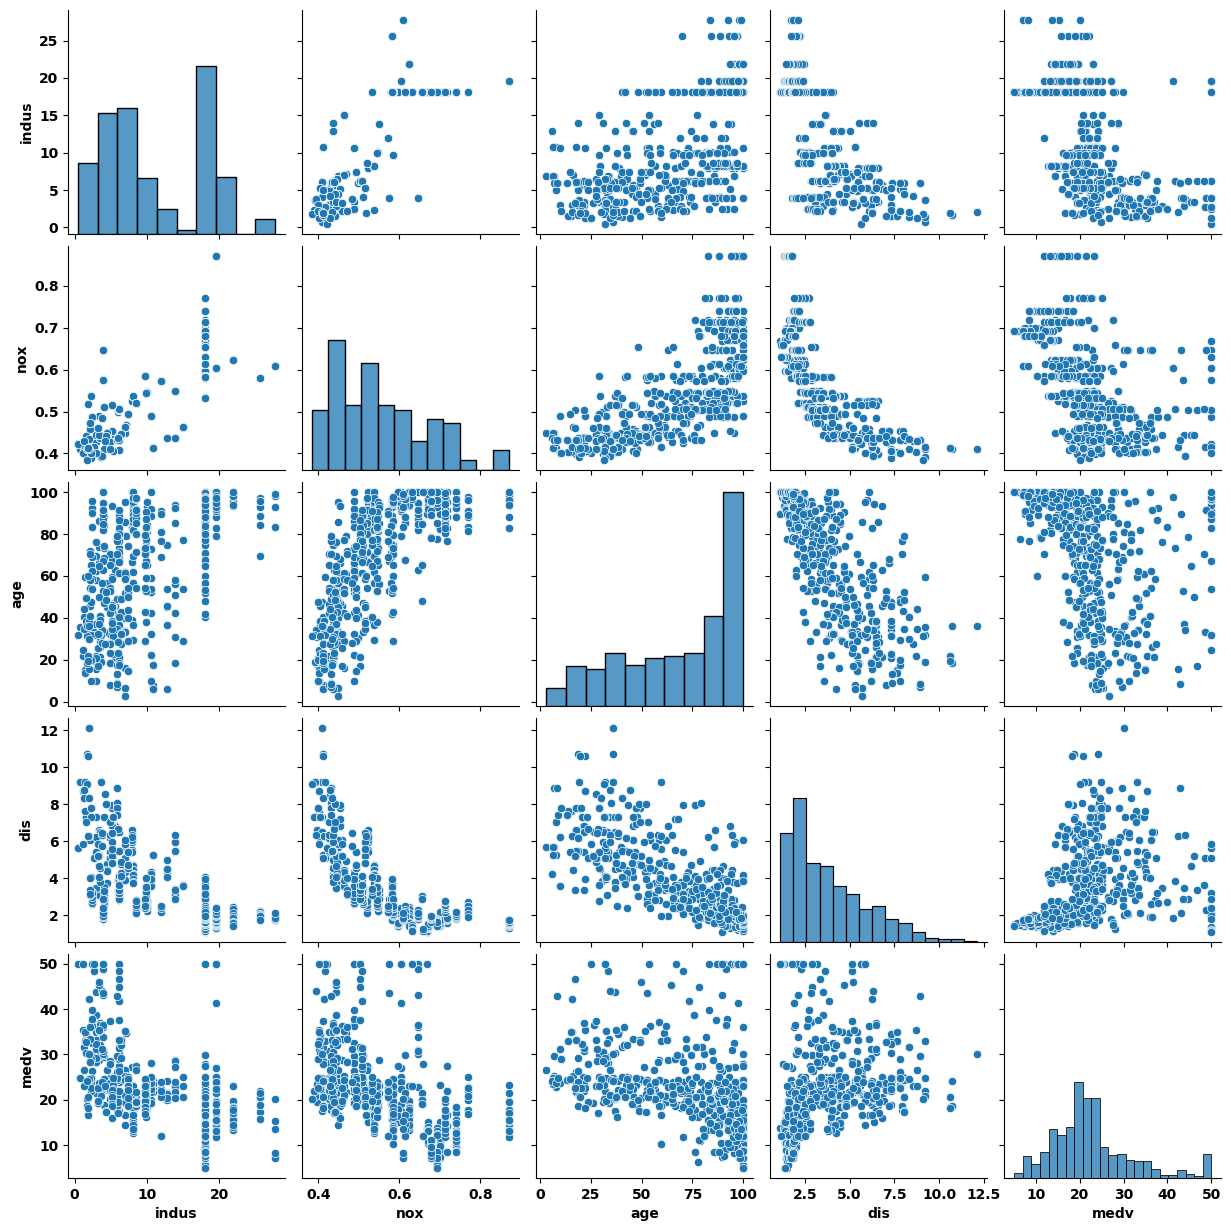

In [36]:
# Select a subset of features for the pairplot
pp_features = ["indus", "nox", "age", "dis", "medv"]

# Create the pairplot
sns.pairplot(Boston[pp_features])

One approach to addressing this issue is to look at VIF `variance_inflation_factor()`

https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

In [37]:
# Get possible feature columns
features_cols = Boston.columns.tolist()
features_cols.remove("medv")

In [38]:
features_df = Boston[features_cols]
for i in range(len(features_df.columns)):
  print(f"VIF for {features_df.columns[i]} {VIF(features_df,i)}")

VIF for crim 2.0779440263553175
VIF for zn 2.842979690883528
VIF for indus 14.446693237434957
VIF for chas 1.1485278078677215
VIF for nox 73.07755810210544
VIF for rm 76.16043106786839
VIF for age 21.350797264892297
VIF for dis 14.576651862220688
VIF for rad 14.732498330482695
VIF for tax 61.225415571348584
VIF for ptratio 78.72710022447247
VIF for lstat 11.04078567141973


remove iteratively the ones that have a higher VIF ratio because they strongly correlate with all others

In [39]:
# Get possible feature columns
features_cols = Boston.columns.tolist()
features_cols.remove("medv")
features_cols.remove("ptratio")
features_cols.remove("nox")
#features_cols.remove("rm")
features_cols.remove("tax")
features_cols.remove("age")
#features_cols.remove("indus")

features_df = Boston[features_cols]
for i in range(len(features_df.columns)):
  print(f"VIF for {features_df.columns[i]} {VIF(features_df,i)}")

VIF for crim 2.073213087627151
VIF for zn 2.2995069353358013
VIF for indus 9.010453297104421
VIF for chas 1.1136100225787595
VIF for rm 15.35710383838197
VIF for dis 9.385852953548246
VIF for rad 4.780178231938287
VIF for lstat 6.77288846570477


Before we fit the model, we'll split the data into training and test sets. The training set will be used to train our regression model, and the test set will be used later to evaluate its performance. We'll use an 80-20 split for the training and test sets, respectively.

In [40]:
# Define the features and the target
y = Boston[["medv"]]
X = features_df

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [41]:
# check the head
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 8), (102, 8), (404, 1), (102, 1))

Now, let's standardize the features in both the training and test sets. Remember, we'll fit the scaler on the training data and use that same scaler to transform both the training and test data. This ensures that the scaling parameters (mean and standard deviation) used for the test set are derived from the training set, preventing any potential data leakage.

In [42]:
ss = StandardScaler().set_output(transform="pandas")
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [43]:
X_train_scaled.head()

,crim,zn,indus,chas,rm,dis,rad,lstat
424,0.615975,-0.499594,1.033430,-0.278089,-1.035606,-0.828479,1.644156,0.612368
232,-0.356816,-0.499594,-0.702785,-0.278089,2.908616,-0.004873,-0.180676,-1.416356
181,-0.416770,-0.499594,-1.248453,-0.278089,-0.211759,-0.580501,-0.750937,-0.452401
190,-0.414189,1.359504,-1.105470,-0.278089,0.936505,1.220815,-0.522833,-1.053147
141,-0.232110,-0.499594,1.586393,-0.278089,-1.812499,-1.118080,-0.636885,2.994633


First use scikit learns `LinearRegression`. Calculate an error metric on the test data and check the intercept and coefficients.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [44]:
#fit model and check MSE
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [45]:
#Check coefficients

print("Coefficients:", lr.coef_)


Coefficients: [[-0.77103575  1.48326685 -1.43548551  1.14757222  3.52783899 -2.70266544
  -0.50862098 -3.70932834]]


In [46]:
#Check intercept
print("Intercept:", lr.intercept_)

Intercept: [22.52450495]


In [47]:
mean_squared_error(y_train, lr.predict(X_train_scaled))

25.443714920491203

In [48]:
mean_squared_error(y_test, lr.predict(X_test_scaled))

28.79332616490381

Next we will compare to statsmodel which does OLS linear regressin.

Remember, statsmodels' OLS method does not automatically add an intercept term to the regression equation, so we need to add a constant column to our feature matrix for the intercept. We need to do this after scaling, or the intercept values will be scaled to zero. We are going to use a simple function from sm.

Wee will need to use `data=add_constant(data)` to both sets of X data.

https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html

In [49]:
# Add a constant to the scaled training data (for intercept)
X_train_scaled_const = sm.add_constant(X_train_scaled)

# Add a constant to the scaled test data as well (optional, if you want to make predictions)
X_test_scaled_const = sm.add_constant(X_test_scaled)

In [50]:
# Check the data
X_train_scaled_const.head()

,const,crim,zn,indus,chas,rm,dis,rad,lstat
424,1.0,0.615975,-0.499594,1.033430,-0.278089,-1.035606,-0.828479,1.644156,0.612368
232,1.0,-0.356816,-0.499594,-0.702785,-0.278089,2.908616,-0.004873,-0.180676,-1.416356
181,1.0,-0.416770,-0.499594,-1.248453,-0.278089,-0.211759,-0.580501,-0.750937,-0.452401
190,1.0,-0.414189,1.359504,-1.105470,-0.278089,0.936505,1.220815,-0.522833,-1.053147
141,1.0,-0.232110,-0.499594,1.586393,-0.278089,-1.812499,-1.118080,-0.636885,2.994633


Use the OLS model from statsmodel package:
https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

In [51]:
# Fit the OLS regression model (notice we are using a lightly different flow here)
# Initalise model with data
ols_model=OLS(y_train, X_train_scaled_const)


# Fit and store results
ols_fit_results = ols_model.fit()



Check the MSE and statistics:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [52]:
# Make predictions on the test set
ols_model_predict = ols_fit_results.predict(X_test_scaled_const)


In [27]:
# Asses model MSE
mean_squared_error(y_test, ols_model_predict)

27.394487676570055

In [28]:
y_test

,medv
342,16.5
504,22.0
140,14.0
43,24.7
28,18.4
...,...
121,20.3
39,30.8
141,14.4
191,30.5


In [29]:
# Print the summary of the regression model with .summary
print(ols_fit_results.summary())


                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     113.3
Date:                sex, 09 jan 2026   Prob (F-statistic):           2.39e-97
Time:                        20:47:42   Log-Likelihood:                -1229.5
No. Observations:                 404   AIC:                             2477.
Df Residuals:                     395   BIC:                             2513.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.3460      0.255     87.504      0.0

The OLS regression results provide a comprehensive overview of our fitted model. Let's interpret the key aspects:

1. **R-squared**: This value (0.740) represents the proportion of the variance for the dependent variable (`medv`) that's explained by independent variables in the model. It indicates that about 74% of the variability in median house value can be explained by our predictors.

2. **Adjusted R-squared**: It adjusts the R-squared value based on the number of predictors in the model. It's a more accurate measure when comparing models with a different number of predictors.

3. **coef**: These are the estimated coefficients for each predictor. For instance, holding all other predictors constant, a one standard deviation increase in `rm` (average number of rooms) is associated with an increase of approximately 3.0044 units in the median house value.

4. **P>|t|**: This column gives the p-values for the hypothesis tests of the coefficients being equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. For example, the p-value for `indus` is 0.713, suggesting that it might not be a significant predictor in the presence of other variables.

5. **Confidence Interval**: The 95% confidence intervals for the coefficients are given in the `[0.025, 0.975]` rows. If zero is not within this range, it suggests that the predictor is statistically significant at the 5% level.

6. **F-statistic and Prob (F-statistic)**: The F-statistic tests the overall significance of the model. The associated Prob (F-statistic) is very small, indicating that our model is statistically significant at a high confidence level.

7. **Skewness and Kurtosis**: These provide information about the shape of the distribution of the residuals. Ideally, for a linear regression model, you'd like the residuals to be normally distributed. The skewness value suggests a deviation from symmetry, and the kurtosis value suggests heavier tails than a normal distribution.

8. **Durbin-Watson**: This statistic tests for autocorrelation in the residuals. A value close to 2 suggests no autocorrelation.

**From the results, we can see that not all predictors are significant.**

Let's look into the residuals (you will need to get the df values and .flatten them):

In [26]:
# Predict the train data
y_train_pred = ols_fit_results.predict(X_train_scaled_const)

# Calculate residuals
residuals_train = y_train["medv"] - y_train_pred

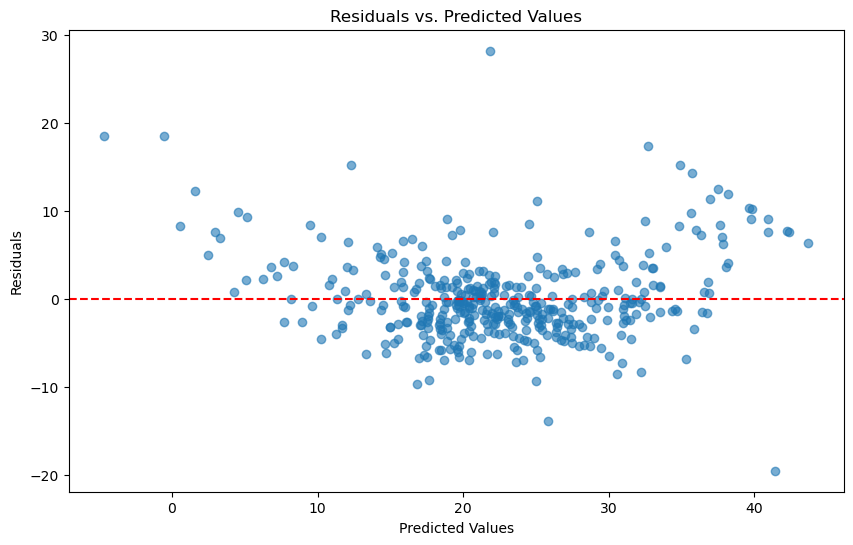

In [27]:
# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, residuals_train, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


Homoscedasticity means that the residuals have constant variance across different levels of the independent variables. A common graphical method to check for homoscedasticity is to plot the residuals against the predicted values (as we did above). A funnel shape in this plot (wider spread of residuals for some range of predicted values) indicates heteroscedasticity. We only see this to a very minor degree here.

The Durbin-Watson test checks for autocorrelation in the residuals. For the Boston dataset, since the data isn't time series or panel data, we wouldn't typically expect autocorrelation in the residuals. However, it's always good to confirm.

The Durbin-Watson statistic ranges from 0 to 4:

A value close to 2 suggests no autocorrelation.
A value towards 0 indicates positive autocorrelation.
A value towards 4 indicates negative autocorrelation.
From our previous OLS summary, the Durbin-Watson value was approximately 2.03, suggesting no significant autocorrelation.

<Figure size 1000x600 with 0 Axes>

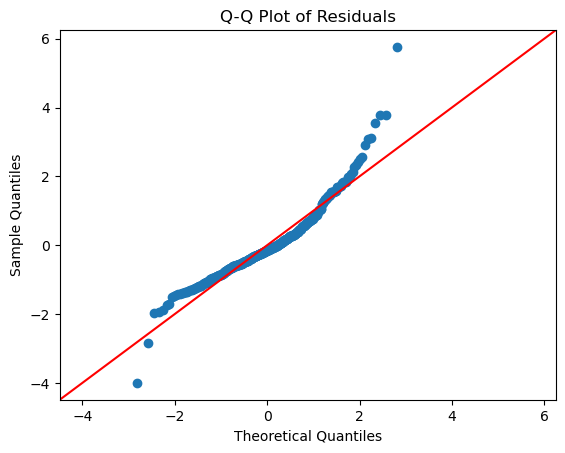

In [28]:
# Plot Q-Q plot for residuals
plt.figure(figsize=(10, 6))
qqplot(residuals_train, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()


The Q-Q plot compares the quantiles of the residuals to the quantiles of a normal distribution. If the residuals were perfectly normal, the points would lie on the 45-degree diagonal reference line. There are some deviations at the tails. This might indicate the presence of a few outliers or that the tails of the residual distribution are somewhat heavier than a normal distribution.

**Outliers** Outliers can greatly influence the coefficients and predictions of a regression model. Here are some ways we can detect outliers:

* Standardized Residuals: Observations with a large absolute value of the standardized residual might be outliers. A common rule of thumb is that observations with standardized residuals greater than 3 in absolute value are potential outliers.
* Leverage Values: These values measure the influence of observations on the fitted regression line. High leverage values can be indicative of observations that are outliers in the X space (features).
* Cook's Distance: It measures the influence of each observation on the model's predictions. A large Cook's distance suggests that the observation is influential and might be an outlier.

Let's start by examining the standardized residuals to detect potential outliers.

Use `.get_influence().resid_studentized_internal` from statsmodel.

https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.get_influence.html

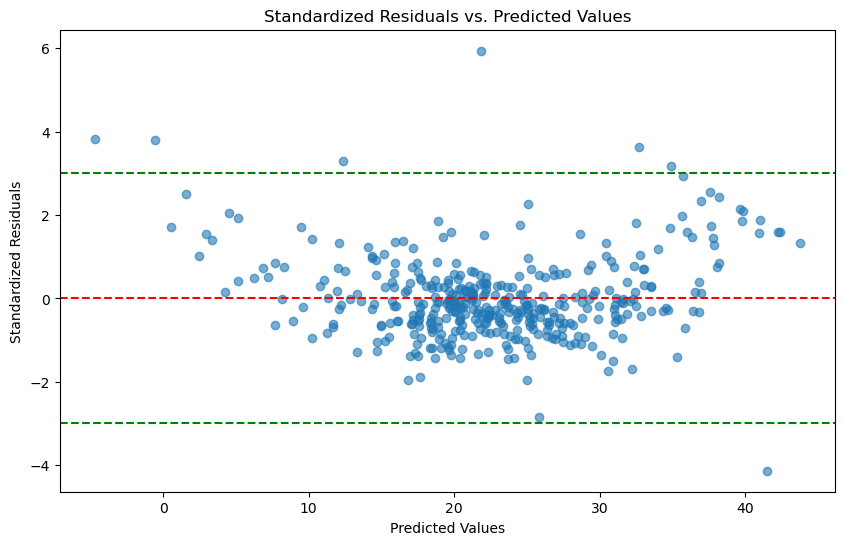

In [29]:
# Calculate standardized residuals
standardized_residuals = ols_fit_results.get_influence().resid_studentized_internal
model_predictions = ols_fit_results.predict(X_train_scaled_const)

# Plot standardized residuals
plt.figure(figsize=(10, 6))
plt.scatter(model_predictions, standardized_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='g', linestyle='--')
plt.axhline(y=-3, color='g', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals vs. Predicted Values')
plt.show()

Observations with standardized residuals greater than 3 or less than -3 in absolute value are considered potential outliers (marked by the green dashed lines). We can see a few points that exceed these thresholds, indicating potential outliers in the data.
The residuals seem to hover around the zero line, indicating that the model's predictions are reasonably well-calibrated.
To address these outliers, there are several approaches:

* Investigate: Before removing or adjusting any outliers, it's essential to investigate the nature of these outliers. Are they due to data entry errors? Or are they genuine extreme values?
* Remove: If you're confident that the outliers are due to errors or are not representative of the population you're studying, you can remove them.
* Transform: You can apply a transformation (like a logarithmic transformation) to the data to reduce the impact of outliers.

**Interactions** are hard to test for unless you just have a couple of variables. They are usually based on domain knowledge. We can use quantile plots and regressions to try to look for potential relationships.

<Figure size 1400x800 with 0 Axes>

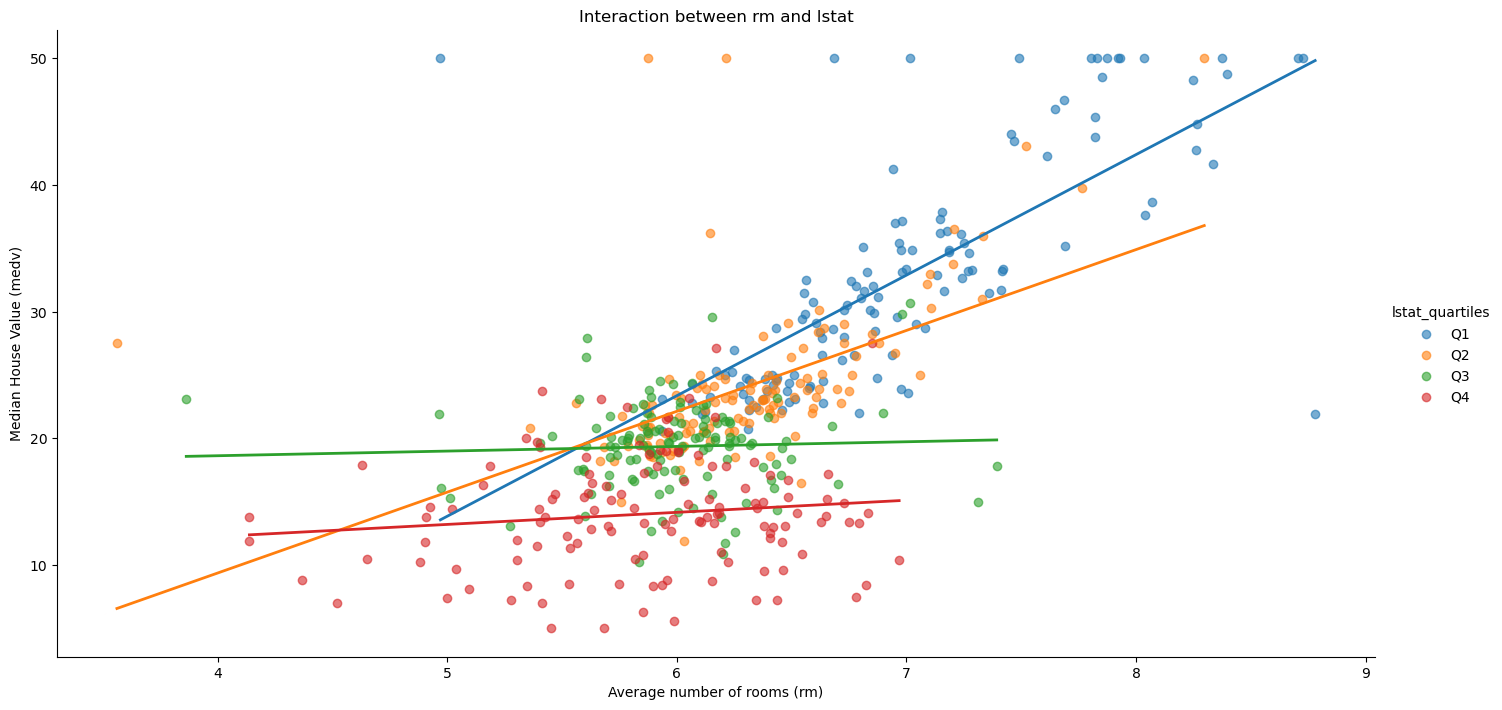

In [30]:
# Segment 'lstat' into quartiles
Boston_Q = Boston.copy()
Boston_Q['lstat_quartiles'] = pd.qcut(Boston_Q['lstat'], 4, labels=["Q1", "Q2", "Q3", "Q4"])

# Scatter plot with regression lines for interaction between rm and lstat
plt.figure(figsize=(14, 8))
sns.lmplot(data=Boston_Q, x='rm', y='medv', hue='lstat_quartiles', ci=None, height=7, aspect=2, scatter_kws={'alpha':0.6}, line_kws={'linewidth':2})
plt.title('Interaction between rm and lstat')
plt.xlabel('Average number of rooms (rm)')
plt.ylabel('Median House Value (medv)')
plt.show()


<Figure size 1400x800 with 0 Axes>

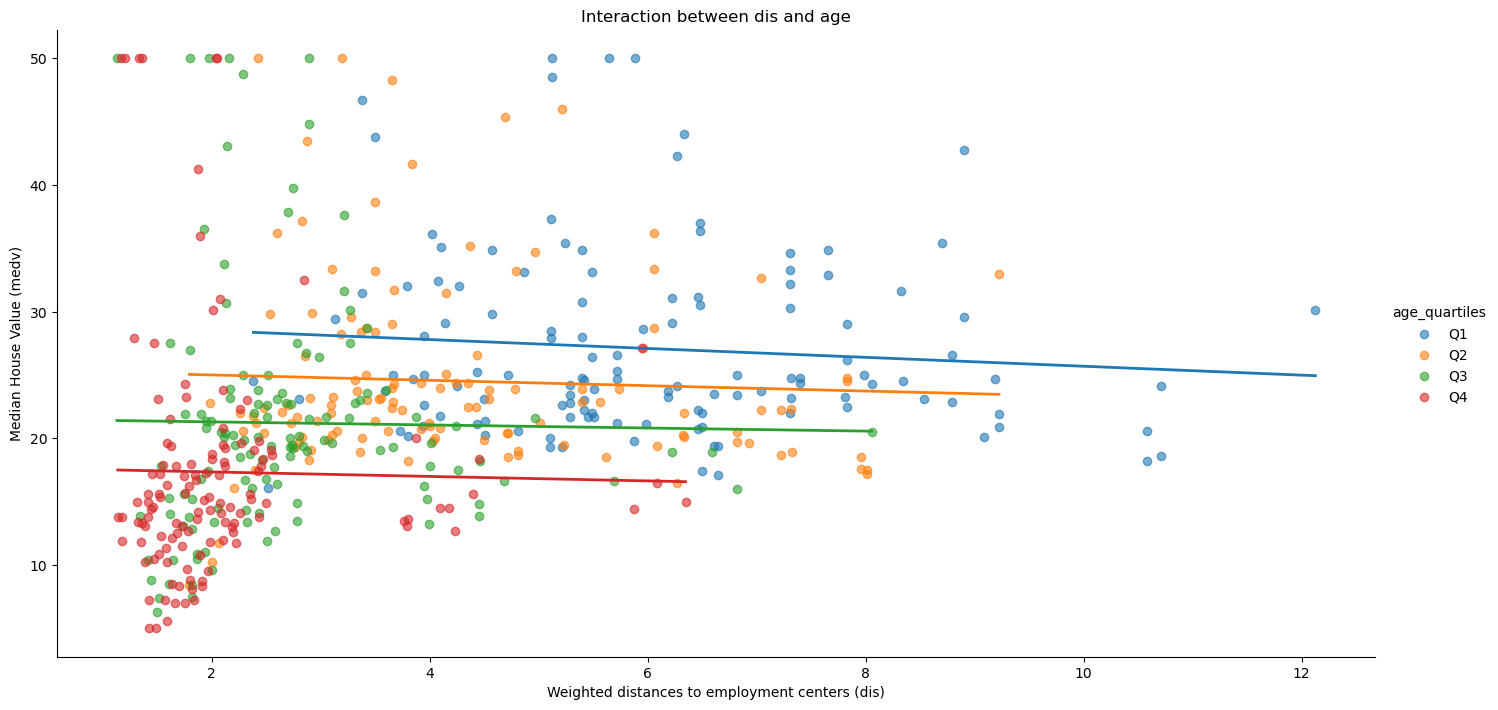

In [31]:
# Segment 'age' into quartiles
Boston_Q['age_quartiles'] = pd.qcut(Boston_Q['age'], 4, labels=["Q1", "Q2", "Q3", "Q4"])

# Scatter plot with regression lines for interaction between age and dis
plt.figure(figsize=(14, 8))
sns.lmplot(data=Boston_Q, x='dis', y='medv', hue='age_quartiles', ci=None, height=7, aspect=2, scatter_kws={'alpha':0.6}, line_kws={'linewidth':2})
plt.title('Interaction between dis and age')
plt.xlabel('Weighted distances to employment centers (dis)')
plt.ylabel('Median House Value (medv)')
plt.show()


Let's try to improve based on our analysis by addint the interaction term.

`df['interaction'] = df['column1'] * df['column2']`

In [32]:
X_train_scaled_const["rm * lstat"] = X_train_scaled_const["rm"] * X_train_scaled_const["lstat"]
X_test_scaled_const["rm * lstat"] = X_test_scaled_const["rm"] * X_test_scaled_const["lstat"]


# Fit the OLS regression model (notice we are using a lightly different flow here)
model = sm.OLS(y_train, X_train_scaled_const)
results =model.fit()

y_pred = results.predict(X_test_scaled_const)

# Asses model MSE
mean_squared_error(y_test, y_pred)


26.710149514921273

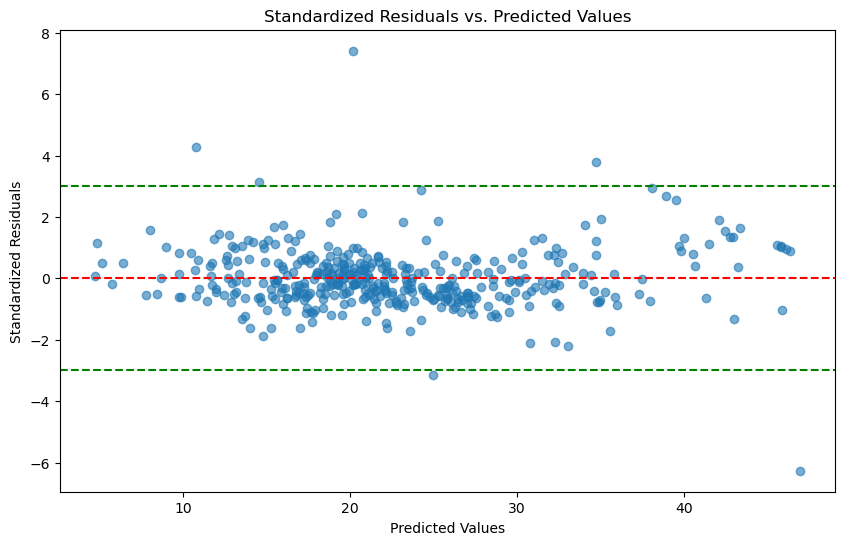

In [33]:
# Calculate standardized residuals
standardized_residuals = results.get_influence().resid_studentized_internal
model_predictions = results.predict(X_train_scaled_const)

# Plot standardized residuals
plt.figure(figsize=(10, 6))
plt.scatter(model_predictions, standardized_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=3, color='g', linestyle='--')
plt.axhline(y=-3, color='g', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals vs. Predicted Values')
plt.show()

In [34]:


# Print the summary of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     195.5
Date:                Sat, 27 Dec 2025   Prob (F-statistic):          2.97e-132
Time:                        11:30:16   Log-Likelihood:                -1147.6
No. Observations:                 404   AIC:                             2313.
Df Residuals:                     395   BIC:                             2349.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.2773      0.236     89.973      0.0

## Qualitative Predictors
Here we use the  `Carseats`  data. We want to attempt to predict `Sales`
(child car seat sales) in 400 locations based on a number of
predictors.

In [35]:
# Load the data
carseats_data = pd.read_csv("11_Carseats.csv")

# Check the head
carseats_data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


The `Carseats`  data includes qualitative predictors such as
 `ShelveLoc`, an indicator of the quality of the shelving
 location --- that is,
the  space within a store in which the car seat is displayed. The predictor
 `ShelveLoc`  takes on three possible values, `Bad`, `Medium`, and `Good`.
Given a qualitative variable such as  `ShelveLoc`, `ModelSpec()` generates dummy
variables automatically.
These variables are often referred to as a *one-hot encoding* of the categorical
feature. Their columns sum to one, so to avoid collinearity with an intercept, the first column is dropped. Below we see
the column `ShelveLoc[Bad]` has been dropped, since `Bad` is the first level of `ShelveLoc`.

**Important: Do we need to drop a column**

Below we fit a multiple regression model that includes some interaction terms.

In [36]:
# Assuming carseats_data is your DataFrame and is already loaded
# Initialize the OneHotEncoder with the 'drop' parameter to avoid multicollinearity
encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")

# Identify categorical columns
categorical_columns = carseats_data.select_dtypes(include=['object']).columns.tolist()

# Use OneHotEncoder to fit and transform the categorical columns; ensure the output is a dense array
encoded_df = encoder.fit_transform(carseats_data[categorical_columns])

# Drop the original categorical columns and concatenate the new one-hot encoded DataFrame
carseats_data_encoded_all = pd.concat([carseats_data.drop(categorical_columns, axis=1), encoded_df], axis=1)

# Display the first few rows of the modified dataset
carseats_data_encoded_all.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,0.0,0.0,1.0,1.0
1,11.22,111,48,16,260,83,65,10,1.0,0.0,1.0,1.0
2,10.06,113,35,10,269,80,59,12,0.0,1.0,1.0,1.0
3,7.40,117,100,4,466,97,55,14,0.0,1.0,1.0,1.0
4,4.15,141,64,3,340,128,38,13,0.0,0.0,1.0,0.0


Our onehotencoder has created a `ShelveLoc_Good`
dummy variable that takes on a value of 1 if the
shelving location is good, and 0 otherwise. It has also created a `ShelveLoc_Medium`
dummy variable that equals 1 if the shelving location is medium, and 0 otherwise.
A bad shelving location corresponds to a zero for each of the two dummy variables.
If we find that that the coefficient for `ShelveLoc_Good` in the regression output is positive this would indicate that a good shelving location is associated with high sales (relative to a bad location). Our p values we also now interpret as relative to the default category.

## Exercise

We've covered a lot!!!

* Build the best model to predict car seat sales that you can using OLS (prediction). Remember to check your model for any issues using the approaches we have seen.

* Find which variables are the most imporant to explaining sales (inference).

* The impact of competitor price level is likely to dependant on the area income. Can you test this idea?

